# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

*Цель проекта:*
Создать модель, которая позволит быстро и надежно определять рыночную стоимость автомобиля.

*Задачи:*

- загрузить данные;
- изучить данные, заполнить пропущенные значения и удалить аномалии;
- подготовить выборки для обучения моделей;
- обучить несколько моделей и подобрать гиперпараметры;
- проанализировать время обучения, время предсказания и качество моделей;
- выбрать лучшую модель и проверить ее качество на тестовой выборке.

**Описание данных:**

- DateCrawled — дата скачивания анкеты из базы;
- VehicleType — тип автомобильного кузова;
- RegistrationYear — год регистрации автомобиля;
- Gearbox — тип коробки передач;
- Power — мощность (л. с.);
- Model — модель автомобиля;
- Kilometer — пробег (км);
- RegistrationMonth — месяц регистрации автомобиля;
- FuelType — тип топлива;
- Brand — марка автомобиля;
- Repaired — была машина в ремонте или нет;
- DateCreated — дата создания анкеты;
- NumberOfPictures — количество фотографий автомобиля;
- PostalCode — почтовый индекс владельца анкеты (пользователя);
- LastSeen — дата последней активности пользователя;
- Price — цена (евро) - целевой признак


## Подготовка данных

In [1]:
!pip install phik==0.10.0 -q
!pip install scikit-learn==1.3.2 -q

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor

import phik

In [2]:
data = pd.read_csv('/datasets/autos.csv', parse_dates=[0, 12, 15])
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Данные загружены в датафрейм pandas. Загруженные данные соответствуют описанию, изменение типов данных не требуется. В столбцах VehicleType, Gearbox, Model, FuelType и Repaired есть пропущенные значения. Пропуски будут заполнены в пайплайне.

In [4]:
data.duplicated().sum()

4

In [5]:
data = data.drop_duplicates()

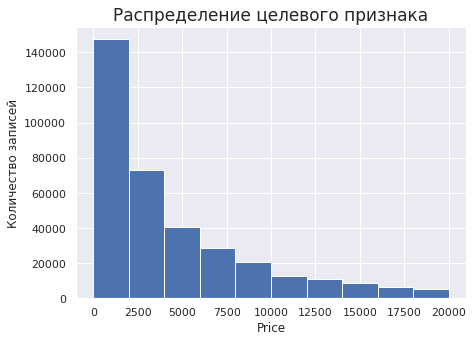

In [6]:
sns.set(rc={'figure.figsize':(7,5)})

data['Price'].plot(kind='hist')
plt.xlabel('Price')
plt.ylabel('Количество записей')
plt.title('Распределение целевого признака', size=17)
plt.show()

In [7]:
data = data.loc[data['Price'] != 0]

Целевая переменная Price принимает значения от 0 до 20000. Однако, значение, равное нулю, не подходит для анализа цен на рынке автомобилей. Возможно, оно было установлено по ошибке или в результате технического сбоя.

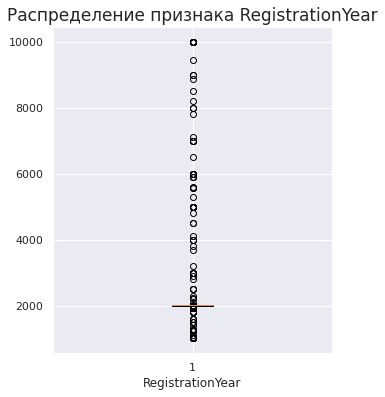

In [8]:
sns.set(rc={'figure.figsize':(5,6)})

plt.boxplot(x = data['RegistrationYear'])
plt.xlabel('RegistrationYear')
plt.title('Распределение признака RegistrationYear', size=17)
plt.show()

In [9]:
data['RegistrationYear'].quantile(0.01)

1980.0

In [10]:
data = data.loc[(data['RegistrationYear'] <= data['DateCreated'].dt.year) & (data['RegistrationYear'] >= 1980)]

Признак RegistrationYear имеет очень большой разброс значений. Ограничим выборку путем удаления 1% минимальных значений (записи до 1980 г). Также учтем, что значение RegistrationYear не должено быть больше года в DateCreated. 

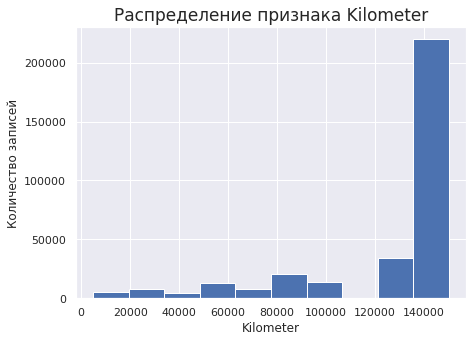

In [11]:
sns.set(rc={'figure.figsize':(7,5)})

data['Kilometer'].plot(kind='hist')
plt.xlabel('Kilometer')
plt.ylabel('Количество записей')
plt.title('Распределение признака Kilometer', size=17)
plt.show()

Данный признак оставим без изменений.

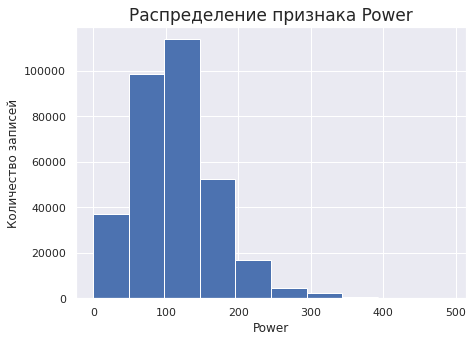

In [12]:
data.loc[data['Power'] < 500, 'Power'].plot(kind='hist')
plt.xlabel('Power')
plt.ylabel('Количество записей')
plt.title('Распределение признака Power', size=17)
plt.show()

In [13]:
data = data.loc[(data['Power'] < 500) & (data['Power'] > 0)]

По графику выбрана верхняя граница мощности 500 л.с., выше которой располагаются менее 0.2% значений. Значения, больше данной границы и значения, равные нулю, будут удалены.

In [14]:
data['DateCrawled'] = data['DateCrawled'].dt.date

In [15]:
data['LastSeen'] = data['LastSeen'].dt.date

In [16]:
data['NumberOfPictures'].value_counts()

0    294261
Name: NumberOfPictures, dtype: int64

Параметр NumberOfPictures для всех записей равен 0. Возможно, фотографии не выгружались, либо произошла ошибка при выгрузке данных. Данный параметр неинформативен и его можно удалить.

In [17]:
data['PostalCode'].value_counts()

10115    798
65428    504
66333    273
60311    261
78224    246
        ... 
21782      1
91744      1
25599      1
25996      1
29578      1
Name: PostalCode, Length: 8114, dtype: int64

In [18]:
data['Price'].corr(data['PostalCode'])

0.0642164751876454

Параметр PostalCode имеет 8132 уникальных значения, и имеет низкую корреляцию с ценой. Данный признак также удалим.

In [19]:
data = data.drop(['NumberOfPictures', 'PostalCode'], axis=1)

In [20]:
data = data.dropna(subset=['Model'])

При предсказании цены важно учитывать модель автомобиля. Восстановить модель по имеющимся данным не представляется возможным, поэтому из датафрейма удалены строки с пропусками в поле Model.

In [21]:
interval_cols = ['Price', 'Power']

In [22]:
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

In [23]:
warnings.filterwarnings('ignore')

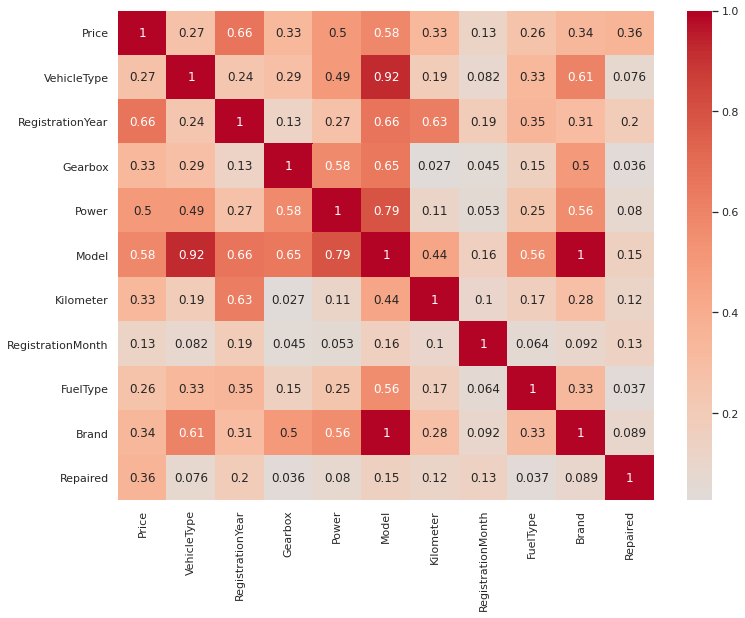

In [24]:
sns.set(rc={'figure.figsize':(12,9)})
sns.heatmap(data.phik_matrix(interval_cols = interval_cols), cmap='coolwarm', center=0, annot=True)
plt.show()

Максимальную корреляцию с целевой переменной имеют признаки: RegistrationYear и Model. Низкая корреляция с признаком RegistrationMonth.

Также видна сильная зависимость между признаками Model и Brand.

Удалим из датафрейма признак RegistrationMonth, имеющий низкую корреляцию с целевой переменной. А также Brand для устранения мультиколлинеарности.

In [25]:
data_for_lr = data.drop(['RegistrationMonth', 'Brand'], axis=1)

In [26]:
data = data.drop(['RegistrationMonth'], axis=1)

In [27]:
data_for_lr.duplicated().sum()

38592

In [28]:
data_for_lr = data_for_lr.drop_duplicates()

In [29]:
data.duplicated().sum()

38527

In [30]:
data = data.drop_duplicates()

Вполнена проверка на наличие дубликатов, удалены дублирующме строки.

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244992 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             244992 non-null  int64 
 1   VehicleType       236040 non-null  object
 2   RegistrationYear  244992 non-null  int64 
 3   Gearbox           240560 non-null  object
 4   Power             244992 non-null  int64 
 5   Model             244992 non-null  object
 6   Kilometer         244992 non-null  int64 
 7   FuelType          232634 non-null  object
 8   Brand             244992 non-null  object
 9   Repaired          209236 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.6+ MB


In [32]:
data['VehicleType'].nunique()

8

In [33]:
data['Gearbox'].nunique()

2

In [34]:
data['Model'].nunique()

248

In [35]:
data['Brand'].nunique()

39

In [36]:
data['FuelType'].nunique()

7

In [37]:
data['Repaired'].nunique()

2

Были устранены аномалии в данных, удалены неинформативные признаки, устранена мультиколлинеарность признаков.

## Обучение моделей

In [38]:
RANDOM_STATE = 1

In [39]:
X = data.drop(['Price'], axis=1)
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [40]:
X_for_lr = data_for_lr.drop('Price', axis=1)
y_for_lr = data_for_lr['Price']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_for_lr, y_for_lr, random_state=RANDOM_STATE)

- Пропуски в VehicleType, Gearbox и FuelType заполним самым частым значением для соответствующей модели. Пропуски в Repaired самым частым значением в датафрейме (предполагаем, что если человек не указал наличие ремонта автомобиля, то он не проводился).
- Количественные переменные масштабируем с помощью MinMaxScaler().
- Model кодируем с помощью OrdinalEncoder(), так как данный признак имеет 248 вариаций.
- VehicleType, Gearbox и FuelType кодируем при помощи OneHotEncoder().

In [41]:
cat_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Model', 'Brand']
cat_columns_lr = ['VehicleType', 'Gearbox', 'FuelType', 'Model']
ohe_columns = ['VehicleType', 'Gearbox', 'FuelType']
num_columns = ['RegistrationYear', 'Kilometer', 'Power']

def engineer_feature(columns, X):
    df = pd.DataFrame(X, columns=columns)
    data['VehicleType'] = data.groupby('Model')['VehicleType'].apply(lambda x: x.fillna(x.value_counts().index[0]))
    data['Gearbox'] = data.groupby('Model')['Gearbox'].apply(lambda x: x.fillna(x.value_counts().index[0]))
    data['FuelType'] = data.groupby('Model')['FuelType'].apply(lambda x: x.fillna(x.value_counts().index[0]))
    return df

rep_transformer = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

encoder_t = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_columns),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), ['Model', 'Brand'])
])

In [42]:
def get_transformer(columns, model_type):
    if model_type == 'not_lr':
        transformer = Pipeline([
            ('engineer', FunctionTransformer(partial(engineer_feature, columns))),
            ('encoder', encoder_t),
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
        ])
    else:
        transformer = Pipeline([
            ('engineer', FunctionTransformer(partial(engineer_feature, columns))),
            ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ])
    return ('cat', transformer, columns)

preprocessor = ColumnTransformer([
    ('rep', rep_transformer, ['Repaired']),
    ('num', MinMaxScaler(), num_columns),
    get_transformer(cat_columns, 'not_lr')
])

In [43]:
pipe_final = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(random_state=RANDOM_STATE, learning_rate=0.15, iterations=1000, verbose=100))
])

В качестве моделей для обучения выбраны: DecisionTreeRegressor(), LinearRegression(), CatBoostRegressor() и LGBMRegressor().

In [45]:
x = get_transformer(cat_columns_lr, 'lr')

params = [
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': [None] + [8, 12],
    },
         
    {
        'model': [LinearRegression()],
        'preprocessor__cat': [x[1]] #[get_transformer(cat_columns_lr, 'lr')]
    },

    {
        'model': [CatBoostRegressor(random_state=RANDOM_STATE, eval_metric='RMSE', loss_function='RMSE')],
        'model__learning_rate': [0.1, 0.15],
        'model__iterations': [1000, 1500],
        'model__verbose': [1500]
    },
    
    {
        'model': [LGBMRegressor(random_state=RANDOM_STATE)],
        'model__learning_rate': [0.1, 0.12],
        'model__n_estimators': [300, 500],
    }
]

In [46]:
grid_search = GridSearchCV(
    pipe_final, 
    params, 
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

0:	learn: 4361.6367916	total: 66.3ms	remaining: 1m 6s
999:	learn: 1478.2888483	total: 14.1s	remaining: 0us
0:	learn: 4354.0060753	total: 15.7ms	remaining: 15.7s
999:	learn: 1467.7360611	total: 13.9s	remaining: 0us
0:	learn: 4353.4535304	total: 16.3ms	remaining: 16.2s
999:	learn: 1474.1549266	total: 14s	remaining: 0us
0:	learn: 4213.2357428	total: 14.3ms	remaining: 14.3s
999:	learn: 1433.4002292	total: 14s	remaining: 0us
0:	learn: 4205.7256947	total: 14.2ms	remaining: 14.2s
999:	learn: 1425.1974354	total: 14.2s	remaining: 0us
0:	learn: 4205.0745305	total: 14.9ms	remaining: 14.9s
999:	learn: 1430.1743381	total: 14.1s	remaining: 0us
0:	learn: 4361.6367916	total: 15.1ms	remaining: 22.6s
1499:	learn: 1435.8587386	total: 21s	remaining: 0us
0:	learn: 4354.0060753	total: 15.4ms	remaining: 23.1s
1499:	learn: 1424.5952802	total: 21.6s	remaining: 0us
0:	learn: 4353.4535304	total: 16.1ms	remaining: 24.1s
1499:	learn: 1430.2831847	total: 21.1s	remaining: 0us
0:	learn: 4213.2357428	total: 14.5ms	rem

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('rep',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Repaired']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['RegistrationYear',
                                                                          'Kilometer',
                                                                          'Power']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('engineer',
                                                                                          Function...
                                                                 OneHotEncoder(drop='first',
                                                                               handle_unknown='ignore'))])]},
                         {'model': [<catboost.core.CatBoostRegressor object at 0x7fc1c0281640>],
                          'model__iterations': [1000, 1500],
                          'model__learning_rate': [0.1, 0.15],
                          'model__verbose': [1500]},
                         {'model': [LGBMRegressor(random_state=1)],
                          'model__learning_rate': [0.1, 0.12],
                          'model__n_estimators': [300, 500]}],
             scoring='neg_root_mean_squared_error')

## Анализ моделей

In [47]:
pd.DataFrame(grid_search.cv_results_)[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score', 'rank_test_score']]

,mean_fit_time,mean_score_time,params,mean_test_score,rank_test_score
0,1.440939,0.770945,{'model': DecisionTreeRegressor(random_state=1...,-1985.447081,10
1,1.116000,0.757310,{'model': DecisionTreeRegressor(random_state=1...,-2082.241350,11
2,1.242182,0.734461,{'model': DecisionTreeRegressor(random_state=1...,-1898.447019,9
3,11.001957,0.887591,"{'model': LinearRegression(), 'preprocessor__c...",-2460.750411,12
4,15.817787,0.775142,{'model': <catboost.core.CatBoostRegressor obj...,-1573.078589,6
5,15.971224,0.787153,{'model': <catboost.core.CatBoostRegressor obj...,-1559.698952,4
6,23.290503,0.802060,{'model': <catboost.core.CatBoostRegressor obj...,-1558.326314,3
7,22.980018,0.799115,{'model': <catboost.core.CatBoostRegressor obj...,-1549.214323,1
8,106.301738,1.942177,"{'model': LGBMRegressor(random_state=1), 'mode...",-1583.071878,8
9,16.800528,2.504563,"{'model': LGBMRegressor(random_state=1), 'mode...",-1563.361812,5


In [48]:
pd.DataFrame(grid_search.cv_results_).loc[5, 'params']

{'model': <catboost.core.CatBoostRegressor at 0x7fc1c0281640>,
 'model__iterations': 1000,
 'model__learning_rate': 0.15,
 'model__verbose': 1500}

Самыми быстрыми по скорости обучения и скорости предсказания оказались модели DecisionTreeRegressor. Самыми точными - модели градиентного бустинга. 

Для заказчика важны все 3 параметра. Так как идет разработка приложения, которой поможет пользователям определять рыночную стоимость своего автомобиля, то с точки зрения пользователей достоинствами являются: время предсказания и точность.

Оптимальной моделью будет являться CatBoostRegressor(learning_rate=0.15, iterations=1000), rank_test_score = 4. Оценка RMSE на кросс-валидации 1559, что не сильно больше минимальной (1549), время предсказания менее 1 секунды. Модель требует довольно большого времени для обучения, однако оно является средним среди моделей градиентного бустинга (которые являются наиболее точными). А также стоит учитывать, что модель требуется обучать заметно реже, чем выполнять предсказания с ее помощью.

In [49]:
pipe_final.fit(X_train, y_train)

0:	learn: 4208.6889958	total: 27.7ms	remaining: 27.7s
100:	learn: 1687.2301871	total: 2.1s	remaining: 18.7s
200:	learn: 1609.0776779	total: 4.2s	remaining: 16.7s
300:	learn: 1569.0971763	total: 6.26s	remaining: 14.5s
400:	learn: 1541.2016190	total: 8.39s	remaining: 12.5s
500:	learn: 1518.9042598	total: 10.5s	remaining: 10.4s
600:	learn: 1501.2005410	total: 12.6s	remaining: 8.36s
700:	learn: 1485.7711995	total: 14.7s	remaining: 6.27s
800:	learn: 1473.6238229	total: 16.8s	remaining: 4.17s
900:	learn: 1461.6022090	total: 19s	remaining: 2.09s
999:	learn: 1451.1026657	total: 21.1s	remaining: 0us


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rep',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Repaired']),
                                                 ('num', MinMaxScaler(),
                                                  ['RegistrationYear',
                                                   'Kilometer', 'Power']),
                                                 ('cat',
                                                  Pipeline(steps=[('engineer',
                                                                   FunctionTransformer(func=functools.p...
                                                                                                    OneHotEncoder(drop='first',
                                                                                                                  handle_unknown='ignore'),
                                                                                                    ['VehicleType',
                                                                                                     'Gearbox',
                                                                                                     'FuelType']),
                                                                                                   ('ord',
                                                                                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                                   unknown_value=nan),
                                                                                                    ['Model',
                                                                                                     'Brand'])])),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Model',
                                                   'Brand'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fc204ec0310>)])

In [50]:
predictions = pipe_final.predict(X_test)

In [51]:
mean_squared_error(y_test, predictions, squared=False)

1560.5526792144592

Оценка RMSE выбранной модели на тестовой выборке 1560.

In [52]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_pred = dummy_regr.predict(X_test)

In [53]:
mean_squared_error(y_test, dummy_pred, squared=False)

4647.897201614091

Результат работы выбранной модели заметно лучше, чем при использовании константной.

## Выводы

Данные были загружены в датафрейм pandas и обработаны аномалии в столбцах:
- удалены строки с нулевым значением целевой переменной Price;
- устранен разброс значений признака RegistrationYear путем удаления 1% минимальных значений (записи до 1980 г) и установкой вехней границы, равной году в DateCreated;
- удалены столбцы NumberOfPictures и PostalCode;
- удалены строки с пропусками в поле Model.

Максимальную корреляцию с целевой переменной имеют признаки: RegistrationYear, Power и Model. Низкая корреляция с признаком RegistrationMonth. Также видна сильная зависимость между признаками Model и Brand.

Из датафрейма удалены признаки, имеющие с низкую корреляцию с целевой переменной.

Выполнена подготовка данных к обучению:
- пропуски в VehicleType, Gearbox и FuelType заполнены самым частым значением для соответствующей модели. Пропуски в Repaired - самым частым значением в датафрейме;
- количественные переменные масштабированы с помощью MinMaxScaler();
- model закодирован с помощью OrdinalEncoder(), так как данный признак имеет 248 вариаций;
- VehicleType, Gearbox и FuelType закодирован при помощи OneHotEncoder().

В качестве моделей для обучения выбраны: DecisionTreeRegressor(), LinearRegression(), CatBoostRegressor() и LGBMRegressor().

Самыми быстрыми по скорости обучения и скорости предсказания оказались модели DecisionTreeRegressor. Самыми точными - модели градиентного бустинга. 

Для заказчика важны все 3 параметра. Так как идет разработка приложения, которой поможет пользователям определять рыночную стоимость своего автомобиля, то с точки зрения пользователей достоинствами являются: время предсказания и точность.

Оптимальной моделью будет являться CatBoostRegressor(learning_rate=0.15, iterations=1000), rank_test_score = 4. Оценка RMSE на кросс-валидации 1568, что не сильно больше минимальной (1549), время предсказания менее 1 секунды. Модель требует довольно большого времени для обучения, однако оно является средним среди моделей градиентного бустинга (которые являются наиболее точными). А также стоит учитывать, что модель требуется обучать заметно реже, чем выполнять предсказания с ее помощью.

Оценка RMSE выбранной модели на тестовой выборке 1550, что намного точнее, чем оценка константной модели 4608.